In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_audio_path = 'data/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/audio/yes/0a7c2a8d_nohash_0.wav'

In [6]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [7]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

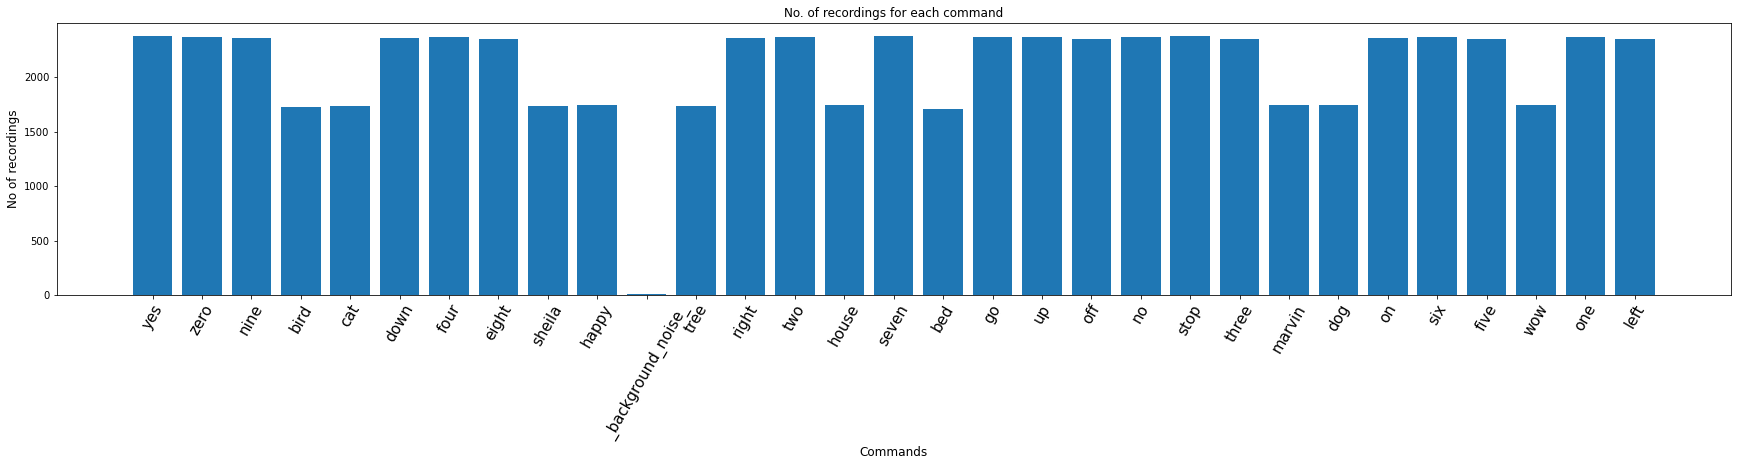

In [8]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

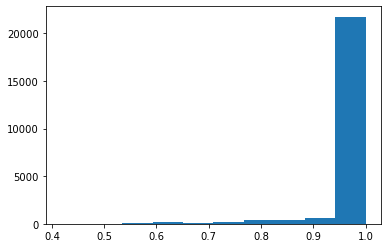

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings));

In [11]:
train_audio_path = 'data/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [12]:
labels

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [17]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(labels))

In [18]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [20]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),
                                            np.array(y),
                                            stratify=y,
                                            test_size = 0.2,
                                            random_state=777,
                                            shuffle=True)

In [21]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=10, 
                   min_delta=0.0001)
mc = ModelCheckpoint('best_model.hdf5',
                     monitor='val_acc',
                     verbose=1,
                     save_best_only=True,
                     mode='max')

In [24]:
history = model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 7s 13ms/step - loss: 2.1265 - accuracy: 0.1950 - val_loss: 2.0209 - val_accuracy: 0.2404
Epoch 2/100
533/533 [==============================] - 6s 12ms/step - loss: 1.6472 - accuracy: 0.3669 - val_loss: 1.4054 - val_accuracy: 0.4903
Epoch 3/100
533/533 [==============================] - 7s 12ms/step - loss: 1.3369 - accuracy: 0.4893 - val_loss: 1.1720 - val_accuracy: 0.5965
Epoch 4/100
533/533 [==============================] - 7s 12ms/step - loss: 1.0933 - accuracy: 0.5929 - val_loss: 1.0010 - val_accuracy: 0.6380
Epoch 5/100
533/533 [==============================] - 6s 12ms/step - loss: 0.9501 - accuracy: 0.6563 - val_loss: 0.8594 - val_accuracy: 0.7080
Epoch 6/100
533/533 [==============================] - 7s 12ms/step - loss: 0.8366 - accuracy: 0.7080 - val_loss: 0.7685 - val_accuracy: 0.7427
Epoch 7/100
533/533 [==============================] - 7s 12ms/step - loss: 0.7671 - accuracy: 0.7315 - val_loss: 0.6687 - val_accuracy:

Epoch 28/100
533/533 [==============================] - 6s 12ms/step - loss: 0.3569 - accuracy: 0.8771 - val_loss: 0.4683 - val_accuracy: 0.8442
Epoch 29/100
533/533 [==============================] - 6s 12ms/step - loss: 0.3468 - accuracy: 0.8803 - val_loss: 0.4760 - val_accuracy: 0.8447
Epoch 30/100
533/533 [==============================] - 7s 12ms/step - loss: 0.3416 - accuracy: 0.8838 - val_loss: 0.5105 - val_accuracy: 0.8358
Epoch 31/100
533/533 [==============================] - 7s 12ms/step - loss: 0.3443 - accuracy: 0.8808 - val_loss: 0.4884 - val_accuracy: 0.8421
Epoch 32/100
533/533 [==============================] - 6s 12ms/step - loss: 0.3291 - accuracy: 0.8869 - val_loss: 0.5070 - val_accuracy: 0.8377
Epoch 33/100
533/533 [==============================] - 6s 12ms/step - loss: 0.3309 - accuracy: 0.8858 - val_loss: 0.4787 - val_accuracy: 0.8454
Epoch 34/100
533/533 [==============================] - 6s 12ms/step - loss: 0.3230 - accuracy: 0.8895 - val_loss: 0.4557 - val_ac

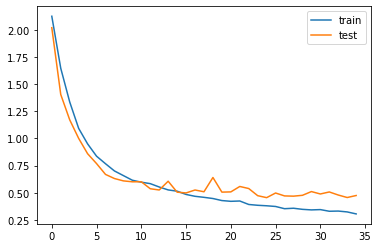

In [26]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
# from tensorflow.keras.models import load_model 
# model = load_model('best_model.hdf5')

In [30]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [31]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: stop


In [32]:
print("Text:",predict(samples))

Text: stop


In [39]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [40]:
# os.listdir('/')
# filepath=''

#reading the voice commands
samples, sample_rate = librosa.load('yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

'yes'